# Reproject Rasters w. Rasterio and Rioxarray

## Reprojecting a Raster with Rioxarray

Far and away the easiest way to handle raster data is by using [rioxarray](https://corteva.github.io/rioxarray/html/index.html). Here's an example of quickly and easily reprojecting a three band landsat image, and writing it to disk.

In order to reproject on the fly we are going to open the raster using `rxr.open_rasterio()`. We can use the `resampling` method when we reproject the image, by default it will be `nearest`, but you can also choose one of ['average', 'bilinear', 'cubic', 'cubic_spline', 'gauss', 'lanczos', 'max', 'med', 'min', 'mode', 'nearest'].

In [1]:
import rioxarray as rxr
from rasterio.enums import Resampling

proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
image = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

# Open and ensure proper data type
src = rxr.open_rasterio(image)

# Convert to float to avoid data type issues during reprojection
src = src.astype('float32')

# Reproject with more explicit parameters
src_reprojected = src.rio.reproject(
    proj4,
    resampling=Resampling.bilinear,
    nodata=0  # Explicitly set nodata value
)

# Convert back to original dtype if needed
if src.dtype != src_reprojected.dtype:
    src_reprojected = src_reprojected.astype(src.dtype)

# Save to file
src_reprojected.rio.to_raster(
    "../../pygis/temp/LC08_20200518_aea.tif",
    compress='lzw',
    tiled=True
)

Let's take a look, remember from earlier that this image is stored as green, blue, red (rather than red, green, blue), so we will use `.sel(band=[3,2,1])` to put them back in the right order.

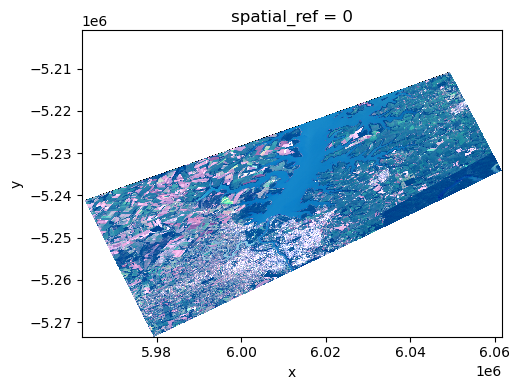

In [6]:
import rioxarray as rxr
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
image = "../../pygis/temp/LC08_20200518_aea.tif"

src = rxr.open_rasterio(image)
rgb_data = src.where(src != 0).isel(band=[2, 1, 0])

# Plot first, then set aspect
rgb_data.plot.imshow(robust=True, ax=ax)
ax.set_aspect('equal')  # This preserves geographic proportions

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

print("Source Transform:\n",src_transform,'\n')
print("Destination Transform:\n", dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


Notice that in order to keep the same number of rows and columns that the resolution of the destination raster increased from 30 meters to 33.24 meters. Also the coordinates of the upper left hand corner have shifted (check $\Delta x, \Delta x$).

## Reprojecting a Raster with Rasterio

Ok finally!

In [8]:
dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open("../../pygis/temp/LC08_20200518_webMC.tif", "w", **dst_kwargs) as dst:
        # iterate through bands
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

<div align="center">
<img src="../../pygis/_static/d_crs/d_reproj_image.png" alt="Reprojected Landsat Image" width="400" style="display: block; margin: 0 auto;">
<p><em>Reprojected Landsat Image</em></p>
</div>